This notebook simply downloads the data used for the datacube from ASF and Hansen. This is so that the tutorial cna be done independent of available data. This is not the thrust of what we are doing, as we expect users will incorporate their own data for segmentation.

# Downloading the Data over the Waxlake

In [1]:
from pathlib import Path
import rasterio
from skimage.restoration import denoise_tv_bregman
import numpy as np
import lxml.etree as etree
import datetime
import matplotlib.pyplot as plt
from rscube import get_cropped_profile, interpolate_nn
from tqdm import tqdm
from itertools import starmap

## Making the Data Directory

We are downloading into a subdirectory within data called `full_coverage`.

In [2]:
DATA_DIR = Path('data/full_coverage/')
DATA_DIR.mkdir(exist_ok=True, parents=True)

## ASF ALOS-1 Radiometrically and Terrain Corrected data

We used the ASF search tool to download data over mangroves in Malaysia. Here is the specific areas within the [search tool](https://search.asf.alaska.edu/#/?zoom=11.066666666666666&center=100.744323,4.539299&polygon=POLYGON((100.4527%204.584,100.746%204.584,100.746%204.9416,100.4527%204.9416,100.4527%204.584))&dataset=ALOS&productTypes=RTC_LOW_RES&beamModes=FBD&resultsLoaded=true&granule=ALPSRP252880080-RTC_LOW_RES&path=490-490&frame=80-80). We then add these images to the queue and download the python script. We have the data in our `data/asf_data/download-alos1-data-malaysaia.py` which we now use. You will need an [Nasa Earthdata login](https://urs.earthdata.nasa.gov/) to proceed.

The first command **should be run in your terminal without the `!`**. We run in it in the cell is so that you can *input your login credentials*. Below is what the output will be.

In [3]:
#!python data/asf_data/download-alos1-plr-wax-lake.py

You can run this from the terminal or the cell.

In [4]:
!unzip '*.zip' -d 'data/asf_data/'

unzip:  cannot find or open *.zip, *.zip.zip or *.zip.ZIP.

No zipfiles found.


In [5]:
rm -rf AP_*.zip

zsh:1: no matches found: AP_*.zip


## Hansen Data

This is aquite a large file so be patient.

In [6]:
# !curl https://storage.googleapis.com/earthenginepartners-hansen/GFC-2019-v1.7/Hansen_GFC-2019-v1.7_last_30N_100W.tif --output data/full_coverage/Hansen_GFC-2019-v1.7_last_30N_100W.tif

# Denoising and Renaming ALOS Data

In [7]:
asf_dir = Path('data/asf_data/')
alos_paths = sorted(list(asf_dir.glob('AP_*/*RT1_H*.tif'))) + sorted(list(asf_dir.glob('AP_*/*RT1_VV.tif')))
alos_paths

[PosixPath('data/asf_data/AP_27644_PLR_F0580_RT1/AP_27644_PLR_F0580_RT1_HH.tif'),
 PosixPath('data/asf_data/AP_27644_PLR_F0580_RT1/AP_27644_PLR_F0580_RT1_HV.tif'),
 PosixPath('data/asf_data/AP_27644_PLR_F0580_RT1/AP_27644_PLR_F0580_RT1_VV.tif')]

In [8]:
def get_alos_date(metadata_xml_path):
    tree = etree.parse(open(metadata_xml_path))
    root = tree.getroot()

    dataAcquisition_elements = root.xpath('//gml:beginPosition', namespaces=root.nsmap)
    assert(len(dataAcquisition_elements) == 1)
    element = dataAcquisition_elements[0].text
    date = datetime.date(int(element[:4]), int(element[5:7]), int(element[8:10]))
    return date

In [9]:
metadata_path = list(asf_dir.glob('AP_*/*.iso.xml'))[0]
retreival_date = get_alos_date(metadata_path)
retreival_date

datetime.date(2011, 4, 3)

In [10]:
def read_one(path, k=1):
    with rasterio.open(path) as ds:
        arr = ds.read(k)
    arr = np.clip(arr, 0, 1)
    arr[arr == 0] = np.nan
    return arr

We get the metadata from the ASF data.

In [11]:
with rasterio.open(alos_paths[0]) as ds:
    ASF_ALOS_PROFILE = ds.profile

In [12]:
quad_pol_data = list(map(read_one, alos_paths))

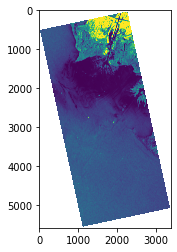

In [13]:
plt.imshow(quad_pol_data[0], vmax=.5)

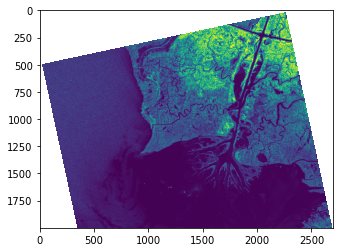

In [14]:
sy = np.s_[:2000]
sx = np.s_[:2700]
plt.imshow(quad_pol_data[0][sy, sx], vmax=.8)

In [15]:
cropped_profile = get_cropped_profile(ASF_ALOS_PROFILE, sx, sy)
cropped_profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 2700, 'height': 2000, 'count': 1, 'crs': CRS.from_epsg(32615), 'transform': Affine(12.5, 0.0, 630062.375,
       0.0, -12.5, 3283822.0), 'tiled': False, 'compress': 'packbits', 'interleave': 'band'}

Now, we are going to crop each image according to these slices.

In [16]:
quad_pol_data_c = list(map(lambda img: img[sy, sx], quad_pol_data))

Our focus is for segmentation, so we need to despeckle our image. We are going to use [`Mulog`](https://www.charles-deledalle.fr/pages/files/mulog_high_quality_version.pdf). We ignore the so-called debiasing because we are going to scale the dynamic range before segmentation to incorporate this data with the Landsat mosaic from Hansen.

In [17]:
def denoise(img):
    # Fill in nodata areas with nearest neighbor
    img_nn = interpolate_nn(img)
    # Convert to db and make noise additive
    img_nn = 10 * np.log10(img_nn)
    # Use TV denoising
    # This parameter lambda = .2 worked well
    # Higher values mean less denoising and lower mean
    # image will appear smoother.
    img_nn_tv = denoise_tv_bregman(img_nn, .2)
    img_denoised = 10**(img_nn_tv / 10.)
    img_denoised[np.isnan(img)] = np.nan
    return img_denoised

We inspect this denoising on a small subset.

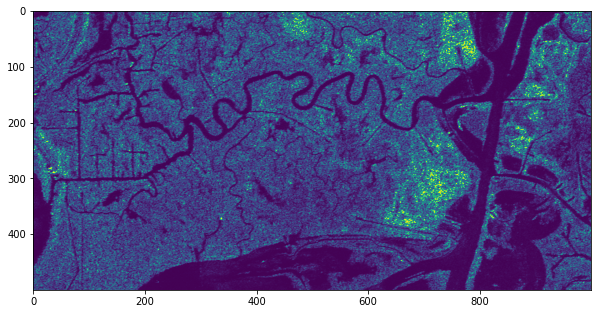

In [18]:
plt.figure(figsize=(10, 10))
X = quad_pol_data_c[0][750:1250, 1000: 2000]
plt.imshow(X)

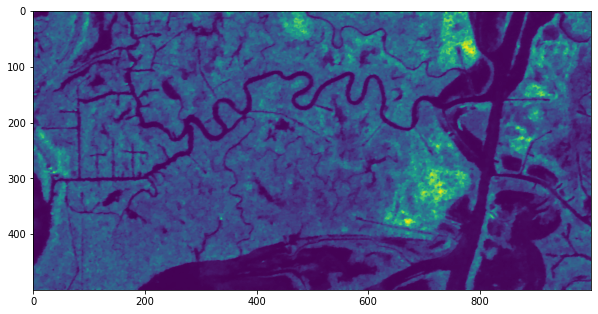

In [19]:
plt.figure(figsize=(10, 10))
X_d = denoise(X)
plt.imshow(X_d)

In [20]:
quad_pol_data_c_tv = list(map(denoise, tqdm(quad_pol_data_c)))

100%|██████████| 3/3 [00:08<00:00,  2.75s/it]


In [21]:
def write_one(arr, dest_path):
    with rasterio.open(dest_path, 'w', **cropped_profile) as ds:
        ds.write(arr.astype(np.float32), 1)
    return dest_path

In [22]:
y, m, d = retreival_date.year, retreival_date.month, retreival_date.day
dest_paths = [DATA_DIR/f'ALOS1_RTC_{pol}_{y}{m}{d}_tv.tif' for pol in ['HH', 'HV', 'VV']]
dest_paths

[PosixPath('data/full_coverage/ALOS1_RTC_HH_201143_tv.tif'),
 PosixPath('data/full_coverage/ALOS1_RTC_HV_201143_tv.tif'),
 PosixPath('data/full_coverage/ALOS1_RTC_VV_201143_tv.tif')]

In [23]:
list(starmap(write_one, zip(tqdm(quad_pol_data_c_tv), dest_paths)))

100%|██████████| 3/3 [00:00<00:00,  7.65it/s]


[PosixPath('data/full_coverage/ALOS1_RTC_HH_201143_tv.tif'),
 PosixPath('data/full_coverage/ALOS1_RTC_HV_201143_tv.tif'),
 PosixPath('data/full_coverage/ALOS1_RTC_VV_201143_tv.tif')]